In [1]:
%load_ext autoreload
%autoreload 2

from qiskit.aqua.algorithms import VQE, NumPyEigensolver
import matplotlib.pyplot as plt
import numpy as np
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit.aqua.operators import Z2Symmetries
from qiskit import IBMQ, BasicAer, Aer
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry import FermionicOperator
from qiskit import IBMQ
from qiskit.aqua import QuantumInstance
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel

import numpy as np
from numpy import pi
# importing Qiskit
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram, plot_bloch_vector
from math import sqrt, pi
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

from qiskit import IBMQ
IBMQ.save_account('78a4e395a27e3cce2d6bea6321d4b618bacc9db3c5f4506850b2616b7444da36b01e2c0d1f27119c77dbbde833366731ea64401e8fab2f852fa84a4c4317a11b', overwrite=True)

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
nqubits = 4
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= nqubits 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)

/home/oryosu/anaconda3/envs/qiskit/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


least busy backend:  ibmq_ourense


Interatomic Distance: 0.5 VQE Result: -0.9147196848903014 Exact Energy: [-1.05515979]
Interatomic Distance: 0.6 VQE Result: -1.03514673882252 Exact Energy: [-1.11628601]
Interatomic Distance: 0.7 VQE Result: -1.0275114266934384 Exact Energy: [-1.13618945]
Interatomic Distance: 0.8 VQE Result: -1.0541877549180243 Exact Energy: [-1.13414767]
Interatomic Distance: 0.9 VQE Result: -1.0470717703154118 Exact Energy: [-1.12056028]
Interatomic Distance: 1.0 VQE Result: -1.035344240693446 Exact Energy: [-1.10115033]
Interatomic Distance: 1.1 VQE Result: -0.9577991905022482 Exact Energy: [-1.07919294]
Interatomic Distance: 1.2 VQE Result: -0.9678622966984927 Exact Energy: [-1.05674075]
Interatomic Distance: 1.3 VQE Result: -0.9705662875370151 Exact Energy: [-1.03518627]
Interatomic Distance: 1.4 VQE Result: -0.9061202002439368 Exact Energy: [-1.01546825]
Interatomic Distance: 1.5 VQE Result: -0.9233889452643967 Exact Energy: [-0.99814935]
Interatomic Distance: 1.6 VQE Result: -0.9020333509950316

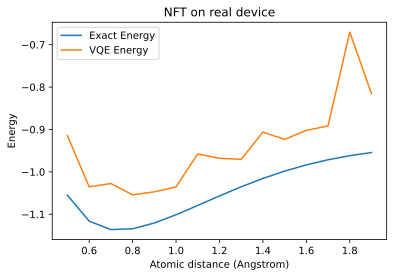

In [2]:
from qiskit.aqua.components.optimizers import NFT
provider = IBMQ.get_provider(hub='ibm-q')
backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmq_ourense")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
quantum_instance = QuantumInstance(backend=backend, 
                                   shots=4096, 
                                   noise_model=noise_model,
                                   coupling_map=coupling_map,
                                   measurement_error_mitigation_cls=CompleteMeasFitter,
                                   cals_matrix_refresh_period=30)

distances = np.arange(0.5, 2.0, 0.1)
exact_energies = []
vqe_energies = []
optimizer = NFT(maxiter=1000)
for dist in distances:
    driver = PySCFDriver(atom='H .0 .0 -{}; H .0 .0 {}'.format(str(dist/2),str(dist/2)), unit=UnitsType.ANGSTROM, charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    qubitOp = ferOp.mapping(map_type='parity')
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    exact_solution = NumPyEigensolver(qubitOp).run()
    exact_energies.append(np.real(exact_solution.eigenvalues) + repulsion_energy)
    #print("Exact Result:", np.real(exact_solution.eigenvalues) + molecule.nuclear_repulsion_energy)
    #print(num_spin_orbitals, num_particles)
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping='parity'
    )
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping='parity'
    )
    vqe = VQE(qubitOp, var_form, optimizer=optimizer)
    ret = vqe.run(quantum_instance)
    vqe_result = np.real(ret['eigenvalue']+ repulsion_energy)
    vqe_energies.append(vqe_result)
    print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result, "Exact Energy:", exact_energies[-1])
    
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.title("NFT on real device")
plt.legend()
plt.savefig("H2_qc_nft.png")
plt.show()

In [2]:
from qiskit.aqua.components.optimizers import COBYLA
provider = IBMQ.get_provider(hub='ibm-q')
backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmqx2")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
quantum_instance = QuantumInstance(backend=backend, 
                                   shots=4096, 
                                   noise_model=noise_model,
                                   coupling_map=coupling_map,
                                   measurement_error_mitigation_cls=CompleteMeasFitter,
                                   cals_matrix_refresh_period=30)

times = 50
distances = np.arange(0.5, 2.0, 0.1)
exact_energies = []
vqe_energies = []
optimizer = COBYLA(maxiter=1000)
for dist in distances:
    driver = PySCFDriver(atom='H .0 .0 -{}; H .0 .0 {}'.format(str(dist/2),str(dist/2)), unit=UnitsType.ANGSTROM, charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    qubitOp = ferOp.mapping(map_type='parity')
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    exact_solution = NumPyEigensolver(qubitOp).run()
    exact_energies.append(np.real(exact_solution.eigenvalues) + repulsion_energy)
    #print("Exact Result:", np.real(exact_solution.eigenvalues) + molecule.nuclear_repulsion_energy)
    #print(num_spin_orbitals, num_particles)
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping='parity'
    )
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping='parity',
        excitation_type = 's'
    )
    vqe = VQE(qubitOp, var_form, optimizer=optimizer)
    ret = vqe.run(quantum_instance)
    vqe_result = np.real(ret['eigenvalue']+ repulsion_energy)
    vqe_energies.append(vqe_result)
    print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result, "Exact Energy:", exact_energies[-1])

<bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7feefe3e2cd0>>
Interatomic Distance: 0.5 VQE Result: -1.0017068829262932 Exact Energy: [-1.05515979]
<bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7feefe3e2d50>>
Interatomic Distance: 0.6 VQE Result: -1.0835899176259074 Exact Energy: [-1.11628601]
<bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7fef058df1d0>>
Interatomic Distance: 0.7 VQE Result: -1.1081715480846803 Exact Energy: [-1.13618945]
<bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7feefe365210>>
Interatomic Distance: 0.8 VQE Result: -1.0976727725501974 Exact Energy: [-1.13414767]
<bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7feefe1f8150>>
Interatomic Distance: 0.9 VQE Result: -1.0739045611

In [7]:
var_form = UCCSD(
    num_orbitals=num_spin_orbitals,
    num_particles=num_particles,
    initial_state=initial_state,
    qubit_mapping='parity',
    excitation_type = 's'
)
print(var_form.setting)

Variational Form: UCCSD
-- num_parameters: 2
-- num_qubits: 2
-- bounds: [(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
-- preferred_init_points: None
-- support_parameterized_circuit: True
-- z2_symmetries: Z2 symmetries:
Symmetries:
Single-Qubit Pauli X:
Cliffords:
Qubit index:
[]
Tapering values:
[]
-- reps: 1
-- num_orbitals: 4
-- num_alpha: 1
-- num_beta: 1
-- num_particles: [1, 1]
-- initial_state: <qiskit.chemistry.components.initial_states.hartree_fock.HartreeFock object at 0x7ff7e709e390>
-- qubit_mapping: parity
-- two_qubit_reduction: True
-- num_time_slices: 1
-- shallow_circuit_concat: True
-- method_singles: both
-- method_doubles: ucc
-- excitation_type: s
-- skip_commute_test: False
-- single_excitations: [[0, 1], [2, 3]]
-- double_excitations: []
-- hopping_ops: [<qiskit.aqua.operators.legacy.weighted_pauli_operator.WeightedPauliOperator object at 0x7ff7e0474710>, <qiskit.aqua.operators.legacy.weighted_pauli_operator.WeightedPauliOpe

In [32]:
from qiskit.aqua.components.optimizers import COBYLA
provider = IBMQ.get_provider(hub='ibm-q')
backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmqx2")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
quantum_instance = QuantumInstance(backend=backend, 
                                   shots=4096, 
                                   noise_model=noise_model,
                                   coupling_map=coupling_map,
                                   measurement_error_mitigation_cls=CompleteMeasFitter,
                                   cals_matrix_refresh_period=30)

times = 50
distances = np.arange(0.5, 2.0, 0.1)
exact_energies = []
vqe_energies = []
optimizer = COBYLA(maxiter=1000)
results = np.zeros([times, len(distances)])
for i in range(times):
    for dist in distances:
        driver = PySCFDriver(atom='H .0 .0 -{}; H .0 .0 {}'.format(str(dist/2),str(dist/2)), unit=UnitsType.ANGSTROM, charge=0, spin=0, basis='sto3g')
        molecule = driver.run()
        repulsion_energy = molecule.nuclear_repulsion_energy
        num_particles = molecule.num_alpha + molecule.num_beta
        num_spin_orbitals = molecule.num_orbitals * 2
        ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
        qubitOp = ferOp.mapping(map_type='parity')
        qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
        exact_solution = NumPyEigensolver(qubitOp).run()
        exact_energies.append(np.real(exact_solution.eigenvalues) + repulsion_energy)
        #print("Exact Result:", np.real(exact_solution.eigenvalues) + molecule.nuclear_repulsion_energy)
        #print(num_spin_orbitals, num_particles)
        initial_state = HartreeFock(
            num_spin_orbitals,
            num_particles,
            qubit_mapping='parity'
        )
        var_form = UCCSD(
            num_orbitals=num_spin_orbitals,
            num_particles=num_particles,
            initial_state=initial_state,
            qubit_mapping='parity'
        )
        vqe = VQE(qubitOp, var_form, optimizer=optimizer)
        ret = vqe.run(quantum_instance)
        vqe_result = np.real(ret['eigenvalue']+ repulsion_energy)
        vqe_energies.append(vqe_result)
        print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result, "Exact Energy:", exact_energies[-1])
    results[i, :] = vqe_energies
    exact_energies = []
    vqe_energies = []

Interatomic Distance: 0.5 VQE Result: -0.9617117993033866 Exact Energy: [-1.05515979]
Interatomic Distance: 0.6 VQE Result: -1.0297699773240274 Exact Energy: [-1.11628601]
Interatomic Distance: 0.7 VQE Result: -1.053825098548086 Exact Energy: [-1.13618945]
Interatomic Distance: 0.8 VQE Result: -1.045484080066474 Exact Energy: [-1.13414767]
Interatomic Distance: 0.9 VQE Result: -1.0617050233424816 Exact Energy: [-1.12056028]
Interatomic Distance: 1.0 VQE Result: -1.026336387432588 Exact Energy: [-1.10115033]
Interatomic Distance: 1.1 VQE Result: -1.0505355052407177 Exact Energy: [-1.07919294]
Interatomic Distance: 1.2 VQE Result: -1.0145034175911323 Exact Energy: [-1.05674075]
Interatomic Distance: 1.3 VQE Result: -0.9991858840961603 Exact Energy: [-1.03518627]
Interatomic Distance: 1.4 VQE Result: -0.9817315587975788 Exact Energy: [-1.01546825]


Process ForkProcess-414585:
KeyboardInterrupt
Traceback (most recent call last):
  File "/home/oryosu/anaconda3/envs/qiskit/lib/python3.7/multiprocessing/process.py", line 290, in _bootstrap
    util._run_after_forkers()
  File "/home/oryosu/anaconda3/envs/qiskit/lib/python3.7/multiprocessing/util.py", line 163, in _run_after_forkers
    items = list(_afterfork_registry.items())
  File "/home/oryosu/anaconda3/envs/qiskit/lib/python3.7/weakref.py", line 210, in items
    def items(self):


QiskitError: 'Keyboard interrupt in parallel_map.'

Process ForkProcess-414586:
Traceback (most recent call last):
  File "/home/oryosu/anaconda3/envs/qiskit/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/oryosu/anaconda3/envs/qiskit/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/oryosu/anaconda3/envs/qiskit/lib/python3.7/concurrent/futures/process.py", line 233, in _process_worker
    call_item = call_queue.get(block=True)
  File "/home/oryosu/anaconda3/envs/qiskit/lib/python3.7/multiprocessing/queues.py", line 94, in get
    res = self._recv_bytes()
  File "/home/oryosu/anaconda3/envs/qiskit/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/oryosu/anaconda3/envs/qiskit/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/oryosu/anaconda3/envs/qiskit/lib/python3.7/multiprocessing/connection.

In [11]:
results

array([[-0.93760356, -1.02270579, -1.06429447, -1.05077195, -1.05241443,
        -1.03785572, -1.02056531, -1.0006262 , -1.00328935, -0.98378485,
        -0.95994199, -0.94124441, -0.92990816, -0.92984802, -0.92555053],
       [-0.93079821, -1.01298385, -1.04833404, -1.05735594, -1.06341759,
        -1.04960572, -1.01925134, -0.98736603, -1.00045365, -0.98081556,
        -0.97014022, -0.95214592, -0.94354049, -0.92342367, -0.9327701 ],
       [-0.94531331, -1.02169357, -1.04925916, -1.06338326, -1.05541303,
        -1.03677989, -1.02331339, -1.00391464, -0.99723716, -0.97674372,
        -0.95589441, -0.95138176, -0.94216041, -0.93228432, -0.92524353],
       [-0.92067941, -1.03869599, -1.06328501, -1.05883833, -1.05683145,
        -1.03052421, -1.02863467, -1.01882229, -0.99743065, -0.97776574,
        -0.96852802, -0.93356639, -0.94054934, -0.9320069 , -0.92702502],
       [-0.95139266, -1.03044206, -1.0612181 , -1.0626778 , -1.06218838,
        -1.04258233, -1.02805503, -1.01022205, 

In [12]:
np.mean(results, axis=0)

array([-0.9423343 , -1.0216686 , -1.05097006, -1.06277518, -1.05719084,
       -1.04117298, -1.02601262, -1.00821088, -0.99285081, -0.97851465,
       -0.96292795, -0.94844346, -0.93904974, -0.93038997, -0.92437805])

Interatomic Distance: 0.5 VQE Result: -1.0420680149248678 Exact Energy: [-1.05515979]
Interatomic Distance: 0.6 VQE Result: -1.1044874744495787 Exact Energy: [-1.11628601]
Interatomic Distance: 0.7 VQE Result: -1.1225388606236044 Exact Energy: [-1.13618945]
Interatomic Distance: 0.8 VQE Result: -1.1147547897218688 Exact Energy: [-1.13414767]
Interatomic Distance: 0.9 VQE Result: -1.087785817302695 Exact Energy: [-1.12056028]
Interatomic Distance: 1.0 VQE Result: -1.066027183859174 Exact Energy: [-1.10115033]
Interatomic Distance: 1.1 VQE Result: -1.036140883024899 Exact Energy: [-1.07919294]
Interatomic Distance: 1.2 VQE Result: -1.0172292003137022 Exact Energy: [-1.05674075]
Interatomic Distance: 1.3 VQE Result: -0.9810873507124593 Exact Energy: [-1.03518627]
Interatomic Distance: 1.4 VQE Result: -0.9484384004083464 Exact Energy: [-1.01546825]
Interatomic Distance: 1.5 VQE Result: -0.9201303155333266 Exact Energy: [-0.99814935]
Interatomic Distance: 1.6 VQE Result: -0.8836891908547782

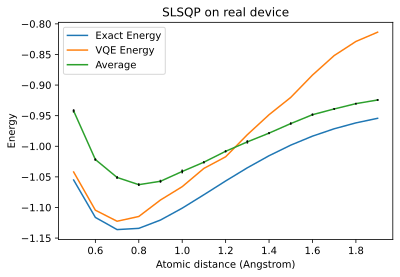

In [29]:
from qiskit.aqua.components.optimizers import SLSQP
provider = IBMQ.get_provider(hub='ibm-q')
backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmqx2")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
quantum_instance = QuantumInstance(backend=backend, 
                                   shots=4096, 
                                   noise_model=noise_model,
                                   coupling_map=coupling_map,
                                   measurement_error_mitigation_cls=CompleteMeasFitter,
                                   cals_matrix_refresh_period=30)

distances = np.arange(0.5, 2.0, 0.1)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=1000)
for dist in distances:
    driver = PySCFDriver(atom='H .0 .0 -{}; H .0 .0 {}'.format(str(dist/2),str(dist/2)), unit=UnitsType.ANGSTROM, charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    qubitOp = ferOp.mapping(map_type='parity')
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    exact_solution = NumPyEigensolver(qubitOp).run()
    exact_energies.append(np.real(exact_solution.eigenvalues) + repulsion_energy)
    #print("Exact Result:", np.real(exact_solution.eigenvalues) + molecule.nuclear_repulsion_energy)
    #print(num_spin_orbitals, num_particles)
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping='parity'
    )
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping='parity',
        excitation_type = 's'
    )
    vqe = VQE(qubitOp, var_form, optimizer=optimizer)
    ret = vqe.run(quantum_instance)
    vqe_result = np.real(ret['eigenvalue']+ repulsion_energy)
    vqe_energies.append(vqe_result)
    print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result, "Exact Energy:", exact_energies[-1])
    
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.plot(distances, np.mean(results, axis=0), label='Average')
plt.errorbar(distances, np.mean(results, axis=0), yerr = np.std(results, ddof=1, axis=0)/ np.sqrt(len(results[0])), fmt='o', markersize=1, ecolor='black', markeredgecolor = "black", color='w')
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.title("SLSQP on real device")
plt.legend()
plt.savefig("H2_qc_slsqp.png")
plt.show()

In [20]:
len(results[0])

15

In [18]:
np.std(results, ddof=1, axis=0)/ np.sqrt(len(results[0]))

array([0.00274733, 0.0020754 , 0.00216842, 0.00221553, 0.00235493,
       0.00304867, 0.00195635, 0.00170903, 0.00266685, 0.00166412,
       0.00173932, 0.00184602, 0.00156114, 0.00110301, 0.00114991])

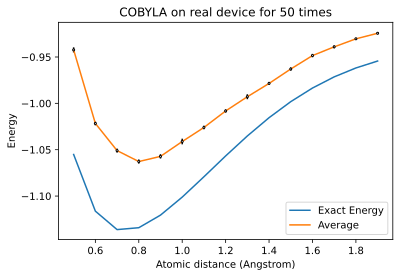

In [27]:
plt.plot(distances, exact_energies, label="Exact Energy")
#plt.plot(distances, vqe_energies, label="VQE Energy")
plt.plot(distances, np.mean(results, axis=0), label='Average')
plt.errorbar(distances, np.mean(results, axis=0), yerr = np.std(results, ddof=1, axis=0)/ np.sqrt(len(results[0])), fmt='o', markersize=2, ecolor='black', markeredgecolor = "black", color='w')
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.title("COBYLA on real device for 50 times")
plt.legend()
plt.savefig("H2_qc_cobyla_50times.png")
plt.show()